/Users/benx/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Homogénea, Activación LogSigmoid, Loss Promedio: 1.3105483532172002e-06, Tiempo Promedio: 0.6202s
Homogénea, Activación ReLU, Loss Promedio: 0.0005813216944261512, Tiempo Promedio: 0.4289s
Homogénea, Activación Tanh, Loss Promedio: 0.0002829704651958309, Tiempo Promedio: 0.4401s
Descendente, Activación LogSigmoid, Loss Promedio: 3.1333100287156414e-05, Tiempo Promedio: 0.7005s
Descendente, Activación ReLU, Loss Promedio: 0.0004785580007592216, Tiempo Promedio: 0.4463s
Descendente, Activación Tanh, Loss Promedio: 0.015987336781108752, Tiempo Promedio: 0.5591s
Profunda, Activación LogSigmoid, Loss Promedio: 0.021385205257683993, Tiempo Promedio: 4.9207s
Profunda, Activación ReLU, Loss Promedio: 0.01997216111049056, Tiempo Promedio: 3.1515s
Profunda, Activación Tanh, Loss Promedio: 0.02037683092057705, Tiempo Promedio: 3.4005s

Mejor Configuración:
Arquitectura: Homogénea ([64, 64, 64, 64, 64])
Función de Activación: LogSigmoid
Pérdida Promedio: 1.3105483532172002e-06


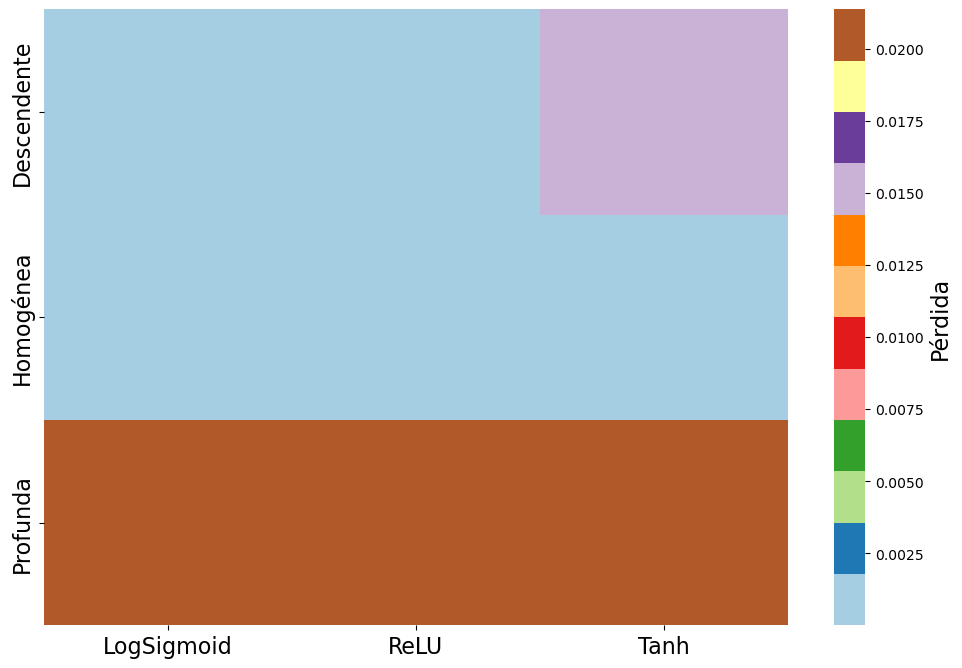

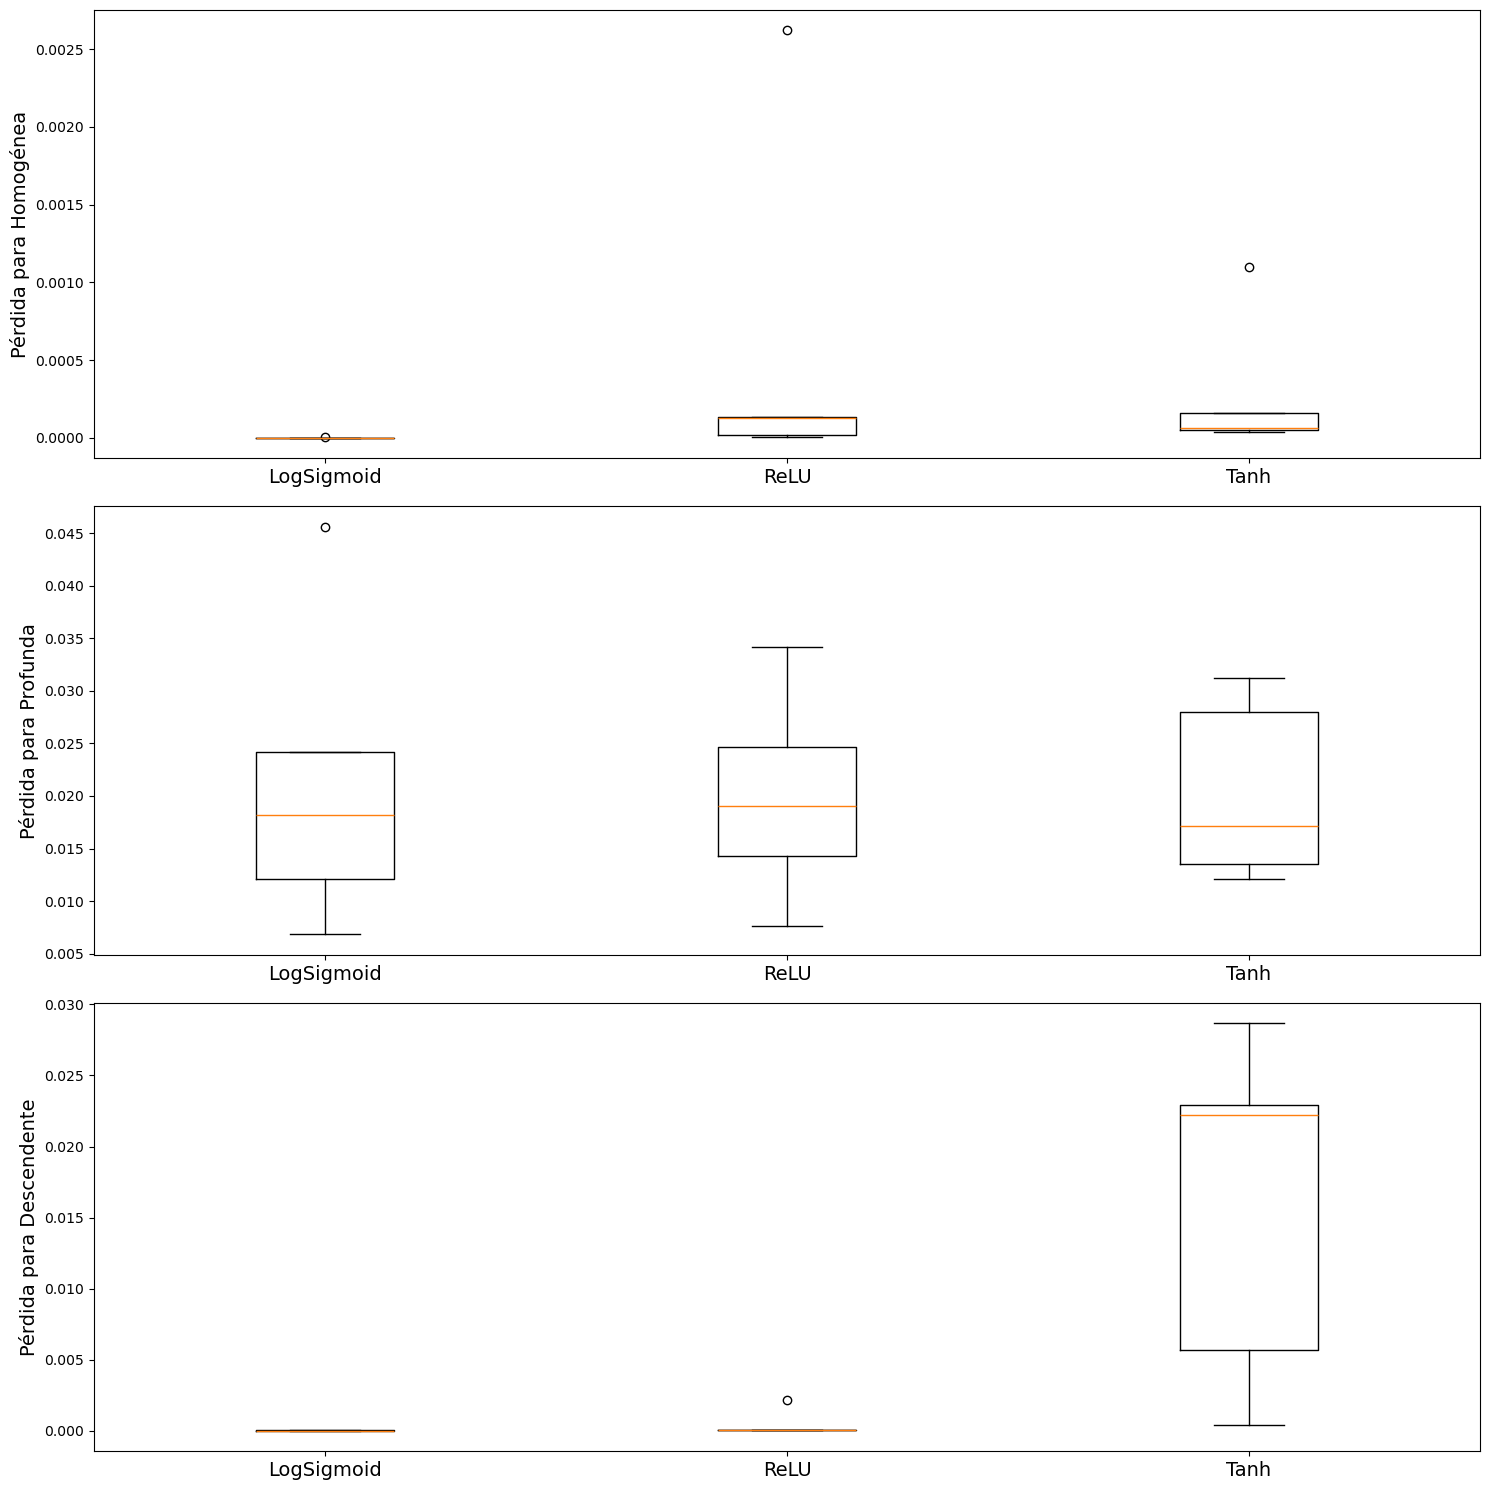

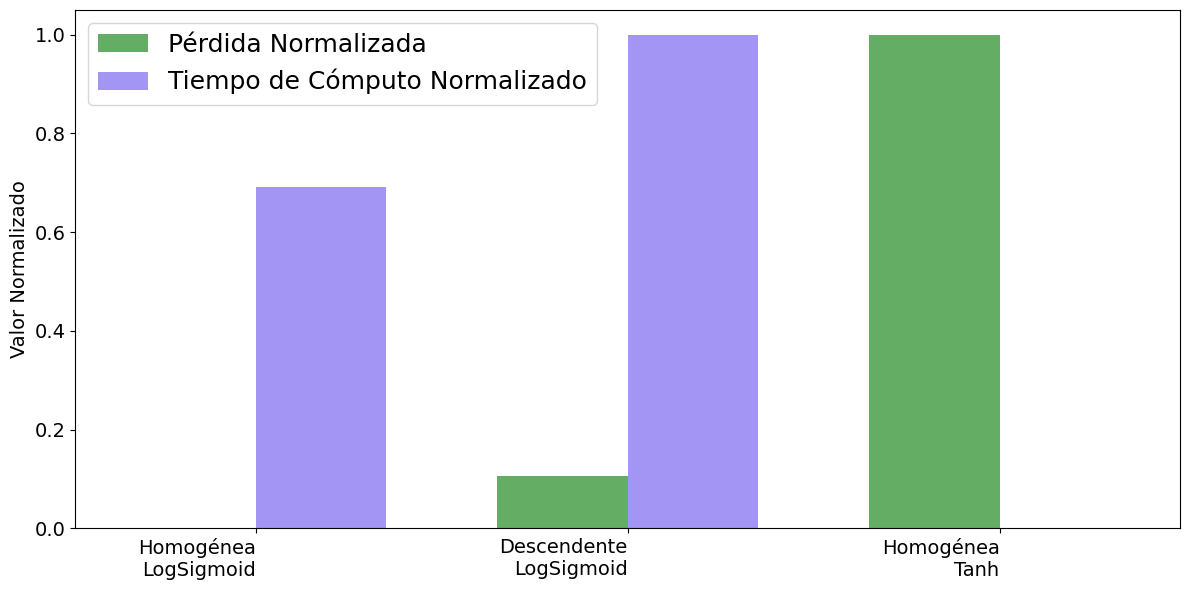

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold
import time

class PINN(nn.Module):
    def __init__(self, arch=[64, 64, 64], activation_func=nn.LogSigmoid(), activation_name='LogSigmoid'):
        super(PINN, self).__init__()
        
        layers = []
        input_size = 1
        for hidden_size in arch:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(activation_func)
            input_size = hidden_size
        
        layers.append(nn.Linear(input_size, 1))
        
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

def generate_data(r):
    M = 2
    g_tt_exact = -(1 - 2 * M / r)
    g_rr_exact = 1 / (1 - 2 * M / r)
    return g_tt_exact, g_rr_exact

def calculate_physics_loss(r, g_tt, g_rr):
    M = 2
    g_00_mod = (g_tt / r**2) + 2 * M / r - 1 
    g_11_r = torch.autograd.grad(g_rr, r, torch.ones_like(g_rr), create_graph=True)[0]
    g_00_r = torch.autograd.grad(g_00_mod, r, torch.ones_like(g_00_mod), create_graph=True)[0]
    
    eq1 = r*g_00_r + g_00_mod + 1
    eq2 = g_rr*g_00_r + g_00_mod*g_11_r
    phys_loss1 = nn.MSELoss()(eq1, torch.zeros_like(eq1))
    phys_loss2 = nn.MSELoss()(eq2, torch.zeros_like(eq2))

    return phys_loss1 + phys_loss2

def train_model(model, R, data, criterion, optimizer, scheduler, num_epochs=300):
    start_time = time.time()
    loss_history = []
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        g_pred = model(R)
        
        data_loss = criterion(g_pred, data)
        
        r_data = R.requires_grad_(True)
        phys_loss = calculate_physics_loss(r_data, model(r_data), model(r_data))
        
        total_loss = data_loss + phys_loss
        
        total_loss.backward()
        optimizer.step()
        
        scheduler.step(total_loss)
        
        loss_history.append(total_loss.item())
        
    end_time = time.time()
    return model, loss_history, end_time - start_time
def create_heatmap(results):
    df = pd.DataFrame({
        'Arquitectura': results['nombres_arquitecturas'],
        'Función Activación': results['nombres_activacion'],
        'Pérdida': results['perdida']
    })
    
    pivot_df = df.pivot_table(
        values='Pérdida', 
        index='Arquitectura', 
        columns='Función Activación'
    )
    
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(
        pivot_df, 
        annot=False, 
        cmap="Paired", 
        fmt=".4f", 
        cbar_kws={'label': 'Pérdida'}  
    )
    cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(16)  

    plt.xlabel("")  # Elimina el título del eje X
    plt.ylabel("")  # Elimina el título del eje Y
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.savefig('HMap4.png')

    plt.show()



def boxplots_by_architecture(results):
    arquitecturas_unicas = list(set(results['nombres_arquitecturas']))
    
    plt.figure(figsize=(15, 5*len(arquitecturas_unicas)))
    
    for i, arquitectura in enumerate(arquitecturas_unicas, 1):
        indices = [j for j, arq in enumerate(results['nombres_arquitecturas']) if arq == arquitectura]
        
        losses_this_arch = [results['fold_losses'][j] for j in indices]
        activations_this_arch = [results['nombres_activacion'][j] for j in indices]
        
        plt.subplot(len(arquitecturas_unicas), 1, i)
        plt.boxplot(losses_this_arch, labels=activations_this_arch)
        #plt.text({arquitectura}, fontsize=18, color='r')
        #plt.title(f"Boxplot de Pérdidas para {arquitectura}")
        plt.ylabel(f"Pérdida para {arquitectura}", fontsize=14)
        #plt.xlabel("Función de Activación")
        plt.xticks(rotation=0, fontsize=14)
    
    plt.tight_layout()
    plt.show()

def plot_top_bottom_models(results):
    df = pd.DataFrame({
        'Arquitectura': results['nombres_arquitecturas'],
        'Función Activación': results['nombres_activacion'],
        'Pérdida Promedio': results['perdida'],
        'Tiempo de Cómputo': results['tiempo_computo']
    })
    
    # Ordenamos por pérdida
    df_sorted = df.sort_values('Pérdida Promedio')
    
    # Seleccionamos los 3 mejores y 3 peores modelos
    top_3 = df_sorted.head(3)
    bottom_3 = df_sorted.tail(0)
    
    # Combinamos los mejores y peores
    plot_df = pd.concat([top_3, bottom_3])
    
    # Normalizacion de la pérdida y tiempo de cómputo
    plot_df['Pérdida Normalizada'] = (plot_df['Pérdida Promedio'] - plot_df['Pérdida Promedio'].min()) / \
                                      (plot_df['Pérdida Promedio'].max() - plot_df['Pérdida Promedio'].min())
    plot_df['Tiempo de Cómputo Normalizado'] = (plot_df['Tiempo de Cómputo'] - plot_df['Tiempo de Cómputo'].min()) / \
                                                (plot_df['Tiempo de Cómputo'].max() - plot_df['Tiempo de Cómputo'].min())
    
    # Etiquetas
    labels = [f"{arq}\n{act}" for arq, act in zip(plot_df['Arquitectura'], plot_df['Función Activación'])]
    
    plt.figure(figsize=(12, 6))
    
    x = np.arange(len(labels))
    width = 0.35
    
    plt.bar(x - width/2, plot_df['Pérdida Normalizada'], width, label='Pérdida Normalizada', color='forestgreen', alpha=0.7)
    plt.bar(x + width/2, plot_df['Tiempo de Cómputo Normalizado'], width, label='Tiempo de Cómputo Normalizado', color='mediumslateblue', alpha=0.7)
    
    # Agregar línea vertical punteada
    #plt.axvline(x=len(labels) / 2 - 0.5, color='black', linestyle='--', linewidth=1.5)#, label='División mitad')
    
    #plt.xlabel('Modelo (Arquitectura - Función Activación)')
    plt.ylabel('Valor Normalizado', fontsize=14)
    #plt.yscale('log')
    #plt.title('Comparación de Pérdida y Tiempo de Cómputo')
    plt.xticks(x, labels, rotation=0, ha='right', fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=18)
    plt.tight_layout()
    plt.savefig('WorstBarX4.png')
    plt.show()

def grid_search_pinn():
    # Nombres de arquitecturas
    #nombres_arquitecturas = ['Perceptrón', 'Homogénea', 'Descendente', 'Profunda'] #
    nombres_arquitecturas = [ 'Homogénea', 'Descendente', 'Profunda'] #

    # Nombres de funciones de activación
    nombres_activacion = [
        'LogSigmoid', 
        'ReLU', 
        'Tanh'#, 
        #'Softmax'
    ]
    
    
    results = {
        'arquitectura': [],
        'nombres_arquitecturas': [],
        'activacion': [],
        'nombres_activacion': [],
        'perdida': [],
        'fold_losses': [],
        'desviacion_estandar': [],
        'tiempo_computo': []
    }
    
    architectures = [
        #[1],                       # Arq A
        5*[64],                    # Arq B
        [256, 128, 64, 32, 16],    # Arq C
        50*[64]                    # Arq D
    ]
    
    activation_functions = [
        (nn.LogSigmoid(), 'LogSigmoid'),
        (nn.ReLU(), 'ReLU'),
        (nn.Tanh(), 'Tanh')#,
        #(nn.Softmax(), 'Softmax')
    ]
    
    learning_rate = 1e-3
    num_folds = 5

    R_max = 30
    r_initial, r_boundary = 10, 30
    R = torch.linspace(r_initial, r_boundary, 30).view(-1, 1).float()
    _, data = generate_data(R.detach().numpy())
    data = torch.tensor(data, dtype=torch.float32).view(-1, 1)

    best_config = {
        'architecture': None,
        'architecture_name': None,
        'activation': None,
        'activation_name': None,
        'avg_loss': float('inf')
    }

    kf = KFold(n_splits=num_folds, shuffle=True)

    for nombre_arq, arch in zip(nombres_arquitecturas, architectures):
        for (activation, nombre_act) in activation_functions:
            fold_losses = []
            fold_times = []

            for fold, (train_idx, val_idx) in enumerate(kf.split(R)):
                R_train, R_val = R[train_idx], R[val_idx]
                data_train, data_val = data[train_idx], data[val_idx]

                model = PINN(arch, activation, nombre_act)
                
                optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, verbose=False)
                
                criterion = nn.MSELoss()

                trained_model, loss_history, computation_time = train_model(
                    model, R_train, data_train, 
                    criterion, optimizer, scheduler
                )

                with torch.no_grad():
                    val_pred = trained_model(R_val)
                    val_loss = criterion(val_pred, data_val)
                    fold_losses.append(val_loss.item())
                    fold_times.append(computation_time)

            avg_fold_loss = np.mean(fold_losses)
            avg_fold_time = np.mean(fold_times)
            
            print(f"{nombre_arq}, Activación {nombre_act}, Loss Promedio: {avg_fold_loss}, Tiempo Promedio: {avg_fold_time:.4f}s")

            results['arquitectura'].append(arch)
            results['nombres_arquitecturas'].append(nombre_arq)
            results['activacion'].append(activation)
            results['nombres_activacion'].append(nombre_act)
            results['perdida'].append(avg_fold_loss)
            results['fold_losses'].append(fold_losses)
            results['desviacion_estandar'].append(np.std(fold_losses))
            results['tiempo_computo'].append(avg_fold_time)

            if avg_fold_loss < best_config['avg_loss']:
                best_config['architecture'] = arch
                best_config['architecture_name'] = nombre_arq
                best_config['activation'] = activation
                best_config['activation_name'] = nombre_act
                best_config['avg_loss'] = avg_fold_loss

    print("\nMejor Configuración:")
    print(f"Arquitectura: {best_config['architecture_name']} ({best_config['architecture']})")
    print(f"Función de Activación: {best_config['activation_name']}")
    print(f"Pérdida Promedio: {best_config['avg_loss']}")

    create_heatmap(results)
    boxplots_by_architecture(results)
    plot_top_bottom_models(results)

    return results, best_config

# Ejecutar búsqueda de hiperparámetros
results, best_config = grid_search_pinn()